Aidan's Investigation Notebook





In [3]:
# Imports
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from scipy import stats
import math  

conn = sqlite3.connect('../../data/im.db')

## Investigating Director on Movie Net Profit (with Walter)

We are investigating the relationship between directors and net profit. To do so, we will take the directors who have made at least 5 movies, sort by their net profit, and only keep the top 10. 

In [4]:
director_AGG = pd.read_sql("""
SELECT pe.primary_name as director, AVG(mob.worldwide_gross - mob.production_budget) as mean_net_profit, COUNT(pe.primary_name) as num_movies
FROM movie_basics mb, principals pr, persons pe, movie_budgets mob
WHERE   mb.movie_id = pr.movie_id 
        AND pr.person_id = pe.person_id
        AND mb.primary_title = mob.movie
        AND pr.category = 'director'
GROUP BY pe.primary_name
HAVING num_movies > 5
ORDER BY mean_net_profit DESC
LIMIT 10
;
""", conn)
director_AGG

,director,mean_net_profit,num_movies
0,Tim Burton,1.908611e+08,6
1,Ridley Scott,1.769673e+08,7
2,Steven Spielberg,1.647550e+08,8
3,Jon M. Chu,1.502429e+08,6
4,Clint Eastwood,1.379160e+08,6
5,Jaume Collet-Serra,7.547862e+07,6
6,Denis Villeneuve,5.732786e+07,6
7,Tim Story,4.845786e+07,9
8,Steven Soderbergh,4.558173e+07,7
9,David Gordon Green,4.236483e+07,8


Graphing the top 10 Directors in terms of mean movie net profit

<Figure size 720x432 with 0 Axes>

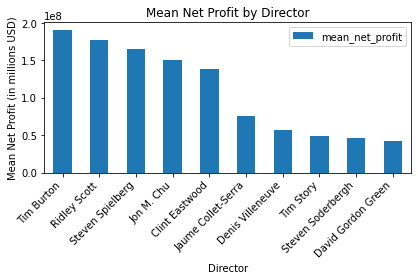

In [5]:
plt.figure(figsize=(10, 6))
director_AGG.plot.bar(x='director', y='mean_net_profit')
plt.title('Mean Net Profit by Director')
plt.xlabel('Director')
plt.ylabel('Mean Net Profit (in millions USD)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Out of the top 10 directors who have made at least 5 movies, the top 5 have a mean net profit per movie that far exceeds the rest. Now, using the aggregated data queried above and unaggregated data queried below, we'll use statistics to prove that the top 10 directors make significantly more profit per movie than the overall population. 

Unaggregated Data (also known as the population). We will compare the top 10 directors to these 3868 directors to prove that starting Computer Vision's studio with movies by directors from the sample will significantly impact success. 

In [6]:
director = pd.read_sql("""
SELECT pe.primary_name as director, (mob.worldwide_gross - mob.production_budget) as net_profit
FROM movie_basics mb, principals pr, persons pe, movie_budgets mob
WHERE   mb.movie_id = pr.movie_id 
        AND pr.person_id = pe.person_id
        AND mb.primary_title = mob.movie
        AND pr.category = 'director'
;
""", conn)
director

,director,net_profit
0,Ethan Coen,42160680
1,Joel Coen,42160680
2,Anbarasan,-700000
3,Dexter Fletcher,22060480
4,Gary Ross,-26762748
...,...,...
3864,Joanna Wierig,-13627243
3865,Zefei Liu,45080579
3866,Chase Pottinger,45080579
3867,Yaser Talebi,-30147513


Our goal is to gain a deeper understanding of the statistics underlying our sample population, with a particular focus on identifying any significant differences between two groups, namely the directors and mean net profits. We aim to test our hypothesis that directors make a significantly higher net profit than the population mean, while rejecting the null hypothesis that they do not.

Hypothesis: (Director) makes significantly more net profit than our population mean.

Null Hypothesis: (Director) does not make significantly more net profit than our population mean. 

The formula for the t-test is as follows:
$$  test\_ statistic = \frac{\bar{x} - \mu}{\frac{\sigma}{\sqrt{n}}} $$

In [7]:
sample_mean = director_AGG['mean_net_profit'].mean()
sample_variance = ((director_AGG['mean_net_profit'] - sample_mean)**2).sum()/(len(director_AGG)-1)
sample_std = math.sqrt(sample_variance)
population_mean = director['net_profit'].mean()

t_test = (sample_mean - population_mean) / (sample_std/math.sqrt(10))

print("Sample mean of mean net profit:", sample_mean)
print("Sample standard deviation of mean net profit:", sample_std)
print("population mean of mean net profit:", population_mean)

Sample mean of mean net profit: 108995329.64623015
Sample standard deviation of mean net profit: 60449890.53309928
population mean of mean net profit: 66560946.470664255


In [8]:
t_test = stats.ttest_1samp(director_AGG['mean_net_profit'], population_mean)
t_test

Ttest_1sampResult(statistic=2.2198435887264627, pvalue=0.05357772228437998)

Conclusion: At the 90% significance level, the top 10 most profitable directors (who have made at least 5 movies) are significantly more successful in terms of profit than the greater population of directors. Using the sample of directors for the first movies of Computer Vision's new studio will greatly help success.

<AxesSubplot:xlabel='net_profit', ylabel='Count'>

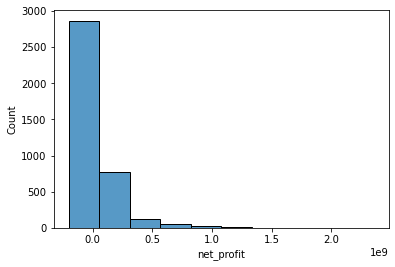

In [14]:
sns.histplot(director, x = director['net_profit'], bins = 10)